# Monte Carlo Methods

In this notebook, it's implementations of many Monte Carlo (MC) algorithms. we use [blackjack game](https://games.washingtonpost.com/games/blackjack) as a environment to illustrate this method.


### Part 0: Explore BlackjackEnv

In [1]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make('Blackjack-v1')

$S$ Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

$A$ The agent has two potential actions:

```python
    STICK = 0
    HIT = 1
```

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Part 1: MC Prediction

In this section, we will implement **MC prediction** for estimating the action-value function $q_{\pi}(s, a)$.  

**Policy $\pi$**: 
- We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  
- In particular, it selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.

**Trajectory**:

The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

**input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

**output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  

In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [48]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state, info = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] # policy
        action = np.random.choice(np.arange(2), p=probs) # sampling from pi(a|s)
        next_state, reward, done, truncated, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [52]:
# play Blackjack with the policy.
for i in range(3):
    print(f"Episode {i}: ", generate_episode_from_limit_stochastic(env))

Episode 0:  [((6, 10, 0), np.int64(1), 0.0), ((10, 10, 0), np.int64(1), 0.0), ((16, 10, 0), np.int64(1), -1.0)]
Episode 1:  [((16, 8, 1), np.int64(1), 0.0), ((16, 8, 0), np.int64(0), -1.0)]
Episode 2:  [((12, 10, 0), np.int64(1), 0.0), ((17, 10, 0), np.int64(1), 0.0), ((21, 10, 0), np.int64(0), 1.0)]


In [ ]:
generate_episode_from_limit_stochastic(env)

#### MC prediction

- Option 1: Every-visit MC Prediction
	- Average the returns following all visits to each state-action pair, in all episodes.

- Option 2: First-visit MC Prediction
	- For each episode, we only consider the first visit to the state-action pair. The pseudocode for this option can be found below.

In here, we use First-Visit MC Prediction. The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

![psedocode](./images/monte-carlo-first-visit-prediction.png)

In [103]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an trajectory sequence using policy
        episode = generate_episode(env)

        # compute return
        states, actions, rewards = zip(*episode)
        discouts = np.array([gamma**i for i in range(len(rewards)+1)])

        visited = set() # comment this to use every-visit
        for i, state in enumerate(states):
            sa_pair = (state, actions[i]) # comment this to use every-visit
            if sa_pair not in visited: # comment this to use every-visit
                visited.add(sa_pair) # comment this to use every-visit
                returns_sum[state][actions[i]] += sum(rewards[i:] * discouts[:-(i+1)])
                N[state][actions[i]] += 1
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

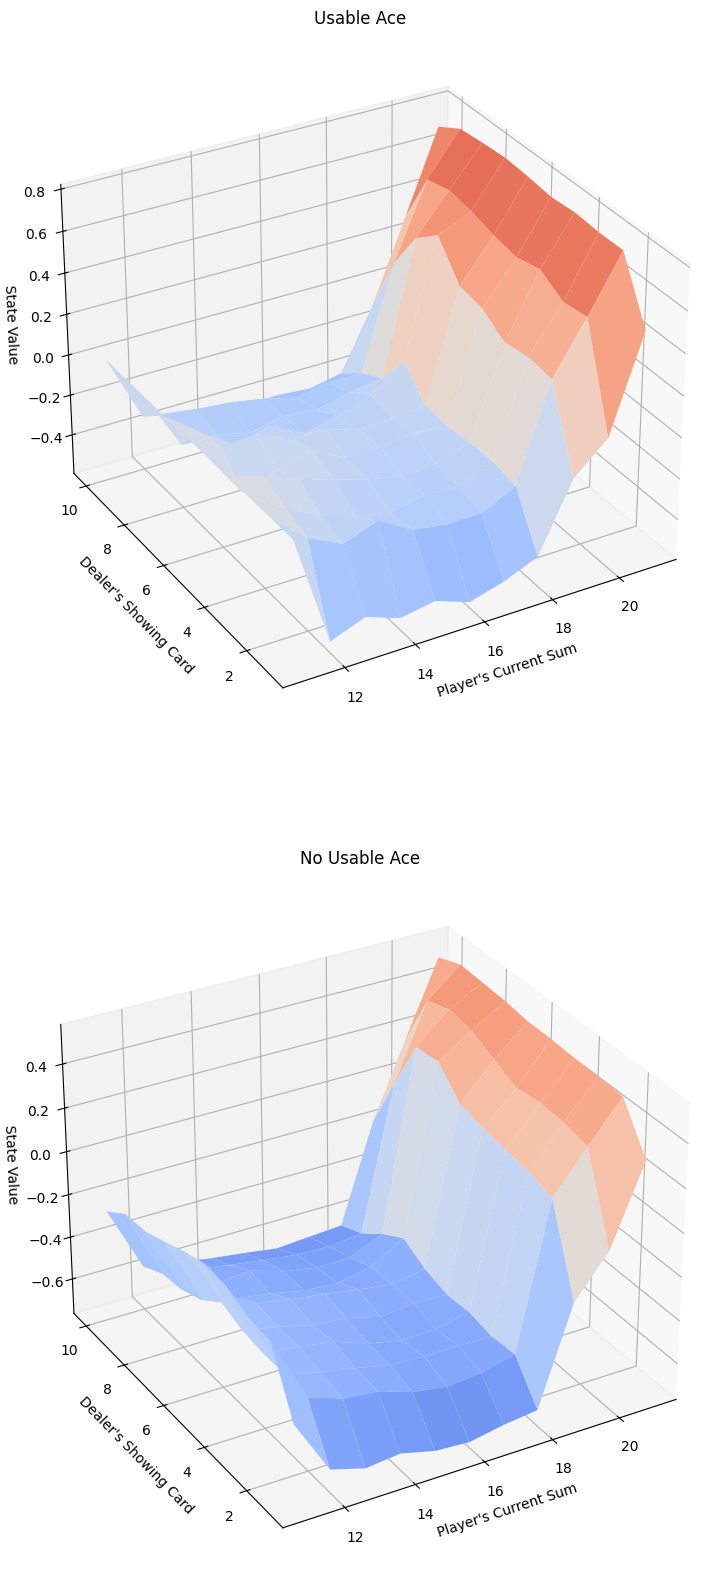

In [104]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [22]:
def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [23]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, ?, ?)

SyntaxError: invalid syntax (3444026864.py, line 2)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)